## Ogólnopolska analiza lagu hydrologicznego

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from imgw_api import get_hydro_metadata,get_meteo_metadata
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Polygon, MultiPolygon
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Wczytanie danych

In [2]:
meteo = pd.read_parquet("../static_data/filtered_meteo_opad_data.parquet.gzip")
hydro = pd.read_parquet("../static_data/filtered_hydro_data.parquet.gzip")
meteo_meta = get_meteo_metadata(True)
hydro_meta = get_hydro_metadata(True)
zlewnie = gpd.read_file('../static_data/zlewnie/zlewnie_2.gpkg')

### Transformacja danych do wspólnego zakresu czasu

In [3]:
full_date_range = pd.date_range(start=hydro['Calendar Date'].min(), end=hydro['Calendar Date'].max(), freq='D')
pivoted = hydro.pivot(index='Calendar Date', columns='Station Code', values='Water Level')
pivoted = pivoted.reindex(full_date_range)
pivoted.index.name = 'Calendar Date'
hydro_std = pivoted.reset_index().melt(id_vars='Calendar Date', var_name='Station Code', value_name='Water Level')

In [4]:
hydro_std.isna().mean()

Calendar Date    0.000000
Station Code     0.000000
Water Level      0.012391
dtype: float64

In [5]:
full_date_range = pd.date_range(start=meteo['Calendar Date'].min(), end=meteo['Calendar Date'].max(), freq='D')
pivoted = meteo.pivot(index='Calendar Date', columns='Station Code', values='Daily Precip Sum')
pivoted = pivoted.reindex(full_date_range)
pivoted.index.name = 'Calendar Date'
meteo_std = pivoted.reset_index().melt(id_vars='Calendar Date', var_name='Station Code', value_name='Daily Precip Sum')

Ilość stacji posiadających min. 50% danych do 2018 roku.

In [6]:
sum(meteo_std[meteo_std['Calendar Date']<'2018-01-01'].pivot(index='Calendar Date', columns='Station Code', values='Daily Precip Sum').isna().mean()<0.5)

C:\Users\Tymek\AppData\Local\Temp\ipykernel_23196\2916860443.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  sum(meteo_std[meteo_std['Calendar Date']<'2018-01-01'].pivot(index='Calendar Date', columns='Station Code', values='Daily Precip Sum').isna().mean()<0.5)


182

Ilość stacji posiadających min. 50% danych do 2015 roku.

In [7]:
sum(meteo_std[meteo_std['Calendar Date']<'2015-01-01'].pivot(index='Calendar Date', columns='Station Code', values='Daily Precip Sum').isna().mean()<0.5)

C:\Users\Tymek\AppData\Local\Temp\ipykernel_23196\3569216005.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  sum(meteo_std[meteo_std['Calendar Date']<'2015-01-01'].pivot(index='Calendar Date', columns='Station Code', values='Daily Precip Sum').isna().mean()<0.5)


224

Przycięcie danych do 2015 roku.

In [8]:
meteo_std = meteo_std[meteo_std['Calendar Date']<'2015-01-01']
hydro_std = hydro_std[hydro_std['Calendar Date']<'2015-01-01']

In [9]:
meteo_std

Calendar Date Station Code  Daily Precip Sum
0          2010-01-01    249180020               1.1
1          2010-01-02    249180020               5.1
2          2010-01-03    249180020               0.6
3          2010-01-04    249180020               0.3
4          2010-01-05    249180020               3.3
...               ...          ...               ...
1302773    2014-12-27    254220060               0.0
1302774    2014-12-28    254220060               0.0
1302775    2014-12-29    254220060               0.0
1302776    2014-12-30    254220060               0.0
1302777    2014-12-31    254220060               2.5

[502150 rows x 3 columns]

In [10]:
gdf_h_zlew = gpd.sjoin(hydro_meta, zlewnie, how="inner", predicate='within').iloc[:,:10].drop('pow',axis=1)
gdf_m_zlew = gpd.sjoin(meteo_meta, zlewnie, how="inner", predicate='within').iloc[:,:9].drop('pow',axis=1)
hydro_std_loc = pd.merge(hydro_std, gdf_h_zlew, how="inner", on="Station Code")
meteo_std_loc = pd.merge(meteo_std, gdf_m_zlew, how="inner", on="Station Code")

In [11]:
meteo_std_loc.drop(columns=['id_hyd_10'], inplace = True)
hydro_std_loc.drop(columns=['id_hyd_10', 'id_hyd_50'], inplace = True)

In [12]:
hydro_std_loc

Calendar Date Station Code  Water Level  Station Name        Lon  \
0          2010-01-01    149180010        201.0  KRZYŻANOWICE  18.287222   
1          2010-01-02    149180010        199.0  KRZYŻANOWICE  18.287222   
2          2010-01-03    149180010        183.0  KRZYŻANOWICE  18.287222   
3          2010-01-04    149180010        164.0  KRZYŻANOWICE  18.287222   
4          2010-01-05    149180010        162.0  KRZYŻANOWICE  18.287222   
...               ...          ...          ...           ...        ...   
1356713    2014-12-27    154230040         44.0         ZELWA  23.458611   
1356714    2014-12-28    154230040         44.0         ZELWA  23.458611   
1356715    2014-12-29    154230040         43.0         ZELWA  23.458611   
1356716    2014-12-30    154230040         43.0         ZELWA  23.458611   
1356717    2014-12-31    154230040         43.0         ZELWA  23.458611   

               Lat                       geometry  index_right  \
0        49.993611  POINT (448926.076 236501.650)            0   
1        49.993611  POINT (448926.076 236501.650)            0   
2        49.993611  POINT (448926.076 236501.650)            0   
3        49.993611  POINT (448926.076 236501.650)            0   
4        49.993611  POINT (448926.076 236501.650)            0   
...            ...                            ...          ...   
1356713  54.026944  POINT (791892.133 693921.933)           42   
1356714  54.026944  POINT (791892.133 693921.933)           42   
1356715  54.026944  POINT (791892.133 693921.933)           42   
1356716  54.026944  POINT (791892.133 693921.933)           42   
1356717  54.026944  POINT (791892.133 693921.933)           42   

                         naz_zlewni  
0        Odra do Nysy Kłodzkiej (l)  
1        Odra do Nysy Kłodzkiej (l)  
2        Odra do Nysy Kłodzkiej (l)  
3        Odra do Nysy Kłodzkiej (l)  
4        Odra do Nysy Kłodzkiej (l)  
...                             ...  
1356713           Czarna Hańcza (l)  
1356714           Czarna Hańcza (l)  
1356715           Czarna Hańcza (l)  
1356716           Czarna Hańcza (l)  
1356717           Czarna Hańcza (l)  

[1356718 rows x 9 columns]

### Uzupełnianie braków danych

In [13]:
hydro_std_loc.isna().sum()

Calendar Date        0
Station Code         0
Water Level      19247
Station Name         0
Lon                  0
Lat                  0
geometry             0
index_right          0
naz_zlewni           0
dtype: int64

In [14]:
hydro_std_loc['Water Level'] = hydro_std_loc.groupby(['Calendar Date', 'index_right'])['Water Level'].transform(lambda x: x.fillna(x.mean()))   

In [15]:
hydro_std_loc.isna().sum()

Calendar Date    0
Station Code     0
Water Level      0
Station Name     0
Lon              0
Lat              0
geometry         0
index_right      0
naz_zlewni       0
dtype: int64

In [16]:
meteo_std_loc.isna().sum()

Calendar Date            0
Station Code             0
Daily Precip Sum    228644
Station Name             0
Lon                      0
Lat                      0
geometry                 0
index_right              0
naz_zlewni               0
dtype: int64

In [17]:
meteo_std_loc['Daily Precip Sum'] = meteo_std_loc.groupby(['Calendar Date', 'index_right'])['Daily Precip Sum'].transform(lambda x: x.fillna(x.mean()))   

In [18]:
meteo_std_loc.isna().sum()

Calendar Date            0
Station Code             0
Daily Precip Sum    101465
Station Name             0
Lon                      0
Lat                      0
geometry                 0
index_right              0
naz_zlewni               0
dtype: int64

In [19]:
meteo_std_loc['Daily Precip Sum'] = meteo_std_loc.groupby(['Calendar Date', 'index_right'])['Daily Precip Sum'].transform(lambda x: x.fillna(x.mean()))   
for station in meteo_std_loc['Station Code'].unique(): 
    meteo_std_loc.loc[meteo_std_loc['Station Code']==station, 'Daily Precip Sum'] = meteo_std_loc.loc[meteo_std_loc['Station Code']==station, 'Daily Precip Sum'].interpolate().ffill().bfill()

In [20]:
meteo_std_loc.isna().sum()

Calendar Date       0
Station Code        0
Daily Precip Sum    0
Station Name        0
Lon                 0
Lat                 0
geometry            0
index_right         0
naz_zlewni          0
dtype: int64

### Dopasowywanie najbliższych stacji hydro i meteo

In [21]:
# stations = []
# for zlew in hydro_std_loc['index_right'].unique():
#     hydro_stat_zlew = gpd.GeoDataFrame(hydro_std_loc[hydro_std_loc['index_right']==zlew].drop('index_right',axis=1), crs=hydro_meta.crs)    
#     meteo_stat_zlew = gpd.GeoDataFrame(meteo_std_loc[meteo_std_loc['index_right'] == zlew].drop('index_right',axis=1), crs=meteo_meta.crs)
#     if len(meteo_stat_zlew) == 0 or len(hydro_stat_zlew) == 0:
#         continue
#     for station in hydro_stat_zlew['Station Code'].unique():
#         stations.append([station, gpd.sjoin_nearest(left_df = hydro_stat_zlew[hydro_stat_zlew['Station Code']==station], right_df = meteo_stat_zlew).iloc[0]['Station Code_right']])
# stations_1.rename(columns={0: "Hydro", 1: "Meteo"}, inplace=True)
# stations_1.to_parquet('hydro_meteo_near.parquet.gzip')

In [22]:
hydro_meteo_near = pd.read_parquet("../static_data/hydro_meteo_near.parquet.gzip")
hydro_meteo_near

Hydro      Meteo
0    149180010  249180030
1    149180020  249180030
2    149180030  249180030
3    149180040  249180030
4    149180050  250180560
..         ...        ...
701  154180040  254180130
702  154180060  254180130
703  154180160  254180130
704  154180230  254180130
705  154190110  254190070

[706 rows x 2 columns]

### Wyliczenie lagu

In [24]:
scaler = MinMaxScaler()
max_lag = 10

In [32]:
stat_lag=[]
stat_lag_multi = []
for idx, row in hydro_meteo_near.iterrows():
    h = hydro_std_loc[hydro_std_loc['Station Code'] == row.Hydro]
    m = meteo_std_loc[meteo_std_loc['Station Code'] == row.Meteo]
    
    df = pd.merge(m[['Daily Precip Sum', 'Calendar Date']], h[['Water Level', 'Calendar Date']], on="Calendar Date", how="inner") 
    df['Daily Precip Sum'] = scaler.fit_transform(df[['Daily Precip Sum']])
    df["Multiple Daily Precip Sum"] = df['Daily Precip Sum'].rolling(window=3).sum() # dodanie sumy opadow w oknie 3 dniowym
    df['Water Level'] = scaler.fit_transform(df[['Water Level']])
    df = df.dropna()
    correlations=[]
    for lag in range(0, max_lag + 1):
        shifted_precip = df["Daily Precip Sum"].shift(lag)
        corr = shifted_precip.corr(df["Water Level"])
        correlations.append((lag, corr))
    best_lag, best_corr = max(correlations, key=lambda x: abs(x[1]))
    lags, corr_vals = zip(*correlations)
    stat_lag.append([row.Hydro, corr_vals, best_lag])

    correlations=[]
    for lag in range(0, max_lag + 1):
        shifted_precip = df["Multiple Daily Precip Sum"].shift(lag)
        corr = shifted_precip.corr(df["Water Level"])
        correlations.append((lag, corr))
        
    best_lag, best_corr = max(correlations, key=lambda x: abs(x[1]))
    lags, corr_vals = zip(*correlations)
    stat_lag_multi.append([row.Hydro, corr_vals, best_lag])
    

In [33]:
stat_lag_df = pd.DataFrame(stat_lag, columns=['Hydro Station', 'Corr values', 'Best lag'])
stat_lag_df = pd.concat([stat_lag_df[['Hydro Station', 'Best lag']], pd.DataFrame(stat_lag_df["Corr values"].tolist())], axis = 1)

stat_lag_multi_df = pd.DataFrame(stat_lag_multi, columns=['Hydro Station', 'Corr values', 'Best lag'])
stat_lag_multi_df = pd.concat([stat_lag_df[['Hydro Station', 'Best lag']], pd.DataFrame(stat_lag_multi_df["Corr values"].tolist())], axis = 1)

In [35]:
stat_lag_multi_df

Hydro Station  Best lag         0         1         2         3  \
0        149180010         2  0.389099  0.461966  0.417955  0.349896   
1        149180020         1  0.366500  0.427106  0.384087  0.328747   
2        149180030         1  0.457801  0.497907  0.401070  0.323059   
3        149180040         1  0.402192  0.486839  0.405025  0.311878   
4        149180050         1  0.371463  0.387233  0.291741  0.226083   
..             ...       ...       ...       ...       ...       ...   
701      154180040         4  0.028338  0.070727  0.094067  0.103766   
702      154180060        10  0.313034  0.330254  0.340077  0.346842   
703      154180160         1  0.201042  0.197551  0.179860  0.167597   
704      154180230         4  0.043917  0.075059  0.086227  0.088537   
705      154190110         2  0.152941  0.198572  0.173707  0.126748   

            4         5         6         7         8         9        10  
0    0.294336  0.246758  0.209337  0.183536  0.164726  0.155073  0.152555  
1    0.278671  0.237687  0.206827  0.186247  0.171035  0.164161  0.162742  
2    0.268012  0.225207  0.186481  0.161772  0.144475  0.144739  0.147423  
3    0.237902  0.191693  0.164017  0.146934  0.129640  0.119748  0.120756  
4    0.184286  0.162642  0.140840  0.131613  0.117239  0.116438  0.116287  
..        ...       ...       ...       ...       ...       ...       ...  
701  0.104353  0.100120  0.093821  0.086266  0.077101  0.067242  0.054492  
702  0.352793  0.358261  0.363947  0.368586  0.372865  0.375351  0.377368  
703  0.156866  0.148252  0.141147  0.135135  0.131246  0.132495  0.136544  
704  0.087910  0.086777  0.084881  0.080475  0.073577  0.064524  0.054106  
705  0.083785  0.049514  0.020774 -0.003445 -0.025148 -0.034664 -0.042766  

[706 rows x 13 columns]

In [36]:
lag = pd.merge(hydro_meta, stat_lag_df, left_on='Station Code', right_on = 'Hydro Station', how="inner") 

In [38]:
lag_multi = pd.merge(hydro_meta, stat_lag_multi_df, left_on='Station Code', right_on = 'Hydro Station', how="inner") 

In [42]:
import io
import base64
import rasterio
# Wczytaj raster
tif_path = "../static_data/chipsomap.tif"
with rasterio.open(tif_path) as src:
    raster = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    # Utwórz obraz PNG w pamięci
    fig2, ax2 = plt.subplots()
    ax2.imshow(raster, extent=extent, cmap='terrain', origin='upper')
    ax2.axis('off')

    buf = io.BytesIO()
    fig2.savefig(buf, format="png", bbox_inches='tight', pad_inches=0, dpi=300)
    buf.seek(0)
    img_bytes = buf.read()
    buf.close()
    plt.close(fig2)

# Zakoduj do base64
img_b64 = base64.b64encode(img_bytes).decode("utf-8")
img_uri = "data:image/png;base64," + img_b64


### Wizualizacja danych

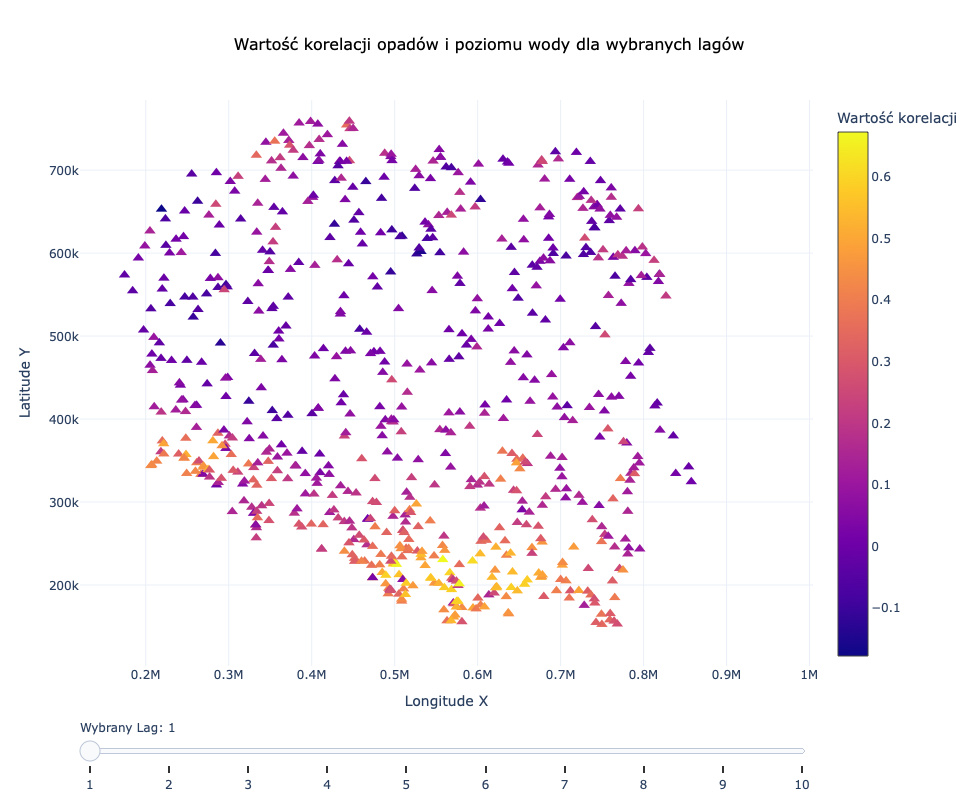

In [53]:
fig = go.Figure()

for i in range(1, 11):
    kolumna_lag = i
    fig.add_trace(go.Scatter(
        x=lag.geometry.x,
        y=lag.geometry.y,
        mode='markers',
        marker=dict(
            symbol='triangle-up',
            size=10,
            color=lag[kolumna_lag],
            colorscale='Plasma',
            showscale=True,
            colorbar=dict(title=f'Wartość korelacji')
        ),
        name=f'Lag {i}',
        visible=(i == 1)
    ))

steps = []
num_zlewnie_traces = len(fig.data) - 10

for i in range(10):
    step = dict(
        method="update",
        args=[{"visible": [True] * num_zlewnie_traces + ([False] * 10)}],
        label=str(i + 1)
    )
    step["args"][0]["visible"][num_zlewnie_traces + i] = True
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Wybrany Lag: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title_text="Wartość korelacji opadów i poziomu wody dla wybranych lagów",
    title_font=dict(size=16, color="black"),
    title_x=0.5,
    xaxis_title="Longitude X",
    yaxis_title="Latitude Y",
    template="plotly_white",
    width=900,
    height=800,
    sliders=sliders,
    legend=dict(
        x=0.01,
        y=0.99,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.7)'
    ),
    images=[dict(
        source=img_uri,
        xref="x",
        yref="y",
        x=bounds.left,
        y=bounds.top,
        sizex=bounds.right - bounds.left,
        sizey=bounds.top - bounds.bottom,
        sizing="stretch",
        opacity=1,
        layer="below"
    )],
    xaxis=dict(range=[225000, 900000]),
    yaxis=dict(range=[bounds.bottom, bounds.top-23000])
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

In [ ]:
import rasterio
# Load the GeoTIFF
tif_path = "../static_data/chipsomap.tif"  # change this to your file path

with rasterio.open(tif_path,'r+') as src:
    raster = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]


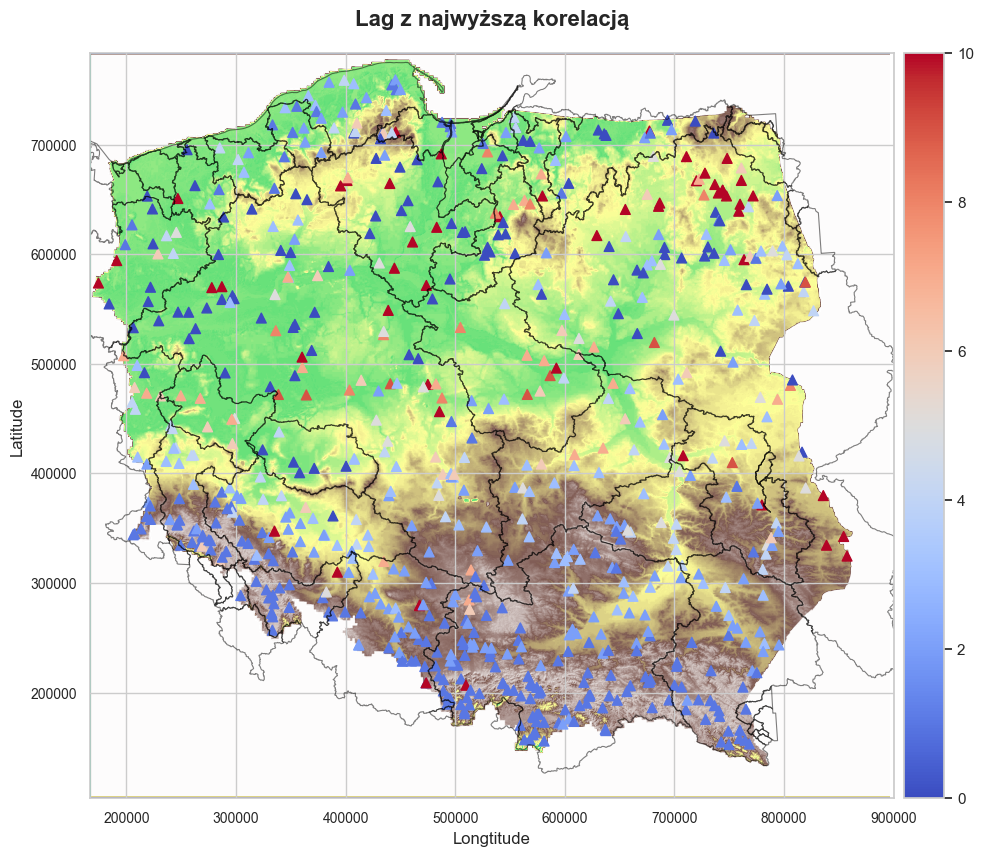

In [59]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(raster, extent=extent, cmap='terrain')
zlewnie.boundary.plot(ax=ax,edgecolor="black", linewidth=0.8, label='Zlewnie',alpha=0.5)
ax.set_title("Lag z najwyższą korelacją", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Longtitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.tick_params(labelsize=10)

cmap = 'coolwarm'
column = 'Best lag'
lag_plot = lag.plot(ax=ax, column=column, cmap=cmap, marker='^', markersize=50, label='Hydro Stations')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

norm = mpl.colors.Normalize(vmin=lag[column].min(), vmax=lag[column].max())
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

cb = plt.colorbar(sm, cax=cax, orientation="vertical")
cb.ax.set_position([cb.ax.get_position().x0,
                    cb.ax.get_position().y0 + 0.1,
                    cb.ax.get_position().width,
                    cb.ax.get_position().height * 0.8])


ax.set_xlim([167000, 900000])  # optional limit
ax.set_ylim([bounds.bottom, bounds.top-23000])
plt.tight_layout()
plt.show()

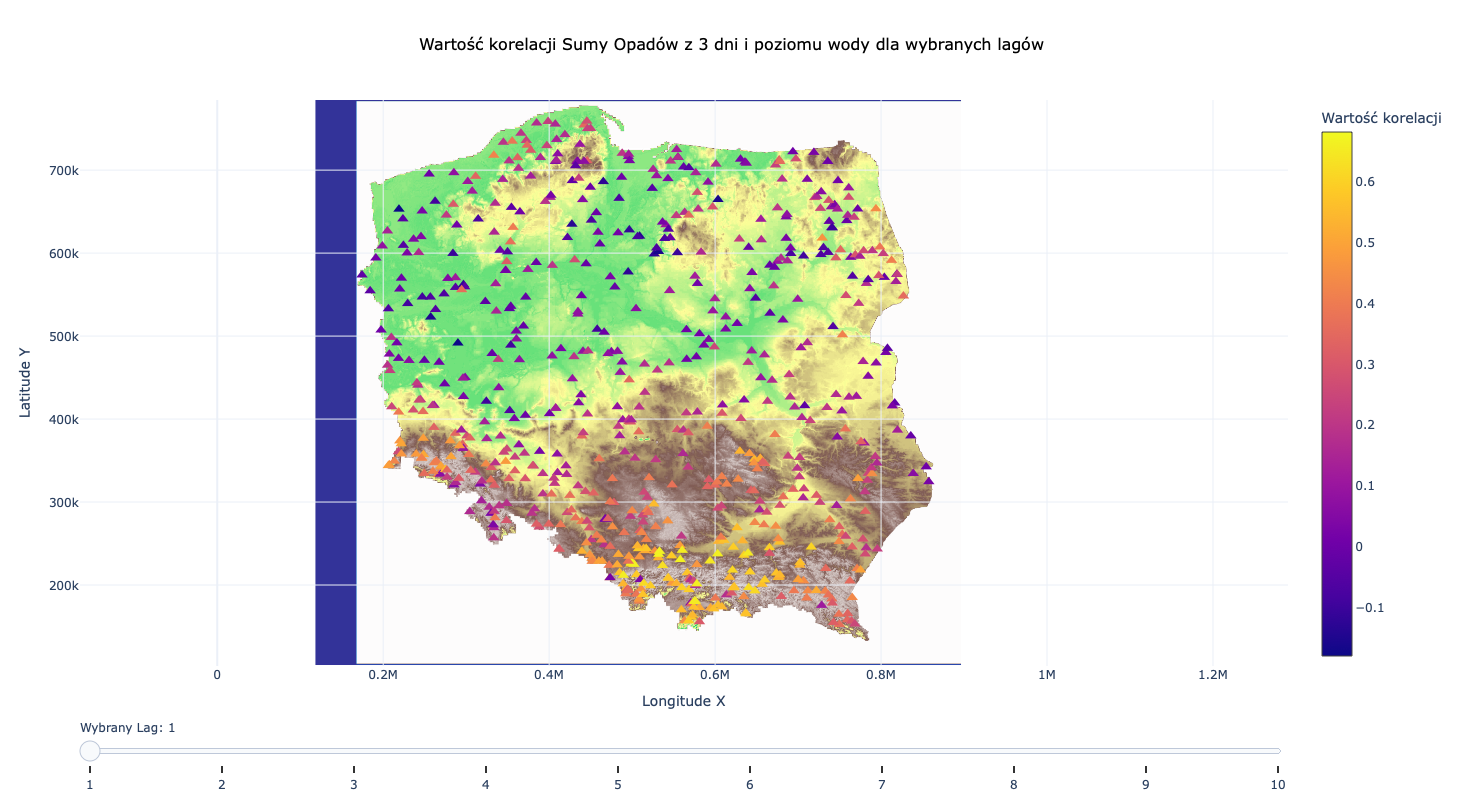

In [55]:
fig = go.Figure()

for i in range(1, 11):
    kolumna_lag = i
    fig.add_trace(go.Scatter(
        x=lag_multi.geometry.x,
        y=lag_multi.geometry.y,
        mode='markers',
        marker=dict(
            symbol='triangle-up',
            size=10,
            color=lag_multi[kolumna_lag],
            colorscale='Plasma',
            showscale=True,
            colorbar=dict(title=f'Wartość korelacji')
        ),
        name=f'Lag {i}',
        visible=(i == 1)
    ))

steps = []
num_zlewnie_traces = len(fig.data) - 10

for i in range(10):
    step = dict(
        method="update",
        args=[{"visible": [True] * num_zlewnie_traces + ([False] * 10)}],
        label=str(i + 1)
    )
    step["args"][0]["visible"][num_zlewnie_traces + i] = True
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Wybrany Lag: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title_text="Wartość korelacji Sumy Opadów z 3 dni i poziomu wody dla wybranych lagów",
    title_font=dict(size=16, color="black"),
    title_x=0.5,
    xaxis_title="Longitude X",
    yaxis_title="Latitude Y",
    template="plotly_white",
    width=900,
    height=800,
    sliders=sliders,
    legend=dict(
        x=0.01,
        y=0.99,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.7)'
    ),
    images=[dict(
        source=img_uri,
        xref="x",
        yref="y",
        x=bounds.left,
        y=bounds.top,
        sizex=bounds.right - bounds.left,
        sizey=bounds.top - bounds.bottom,
        sizing="stretch",
        opacity=1,
        layer="below"
    )],
    xaxis=dict(range=[225000, 900000]),
    yaxis=dict(range=[bounds.bottom, bounds.top-23000])
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()